# Example 1: Function Fitting

In this example, we will cover how to leverage grid refinement to maximimze KANs' ability to fit functions

## CUDA Setup Check
**IMPORTANT**: If you just installed CUDA PyTorch, you need to:
1. **Restart Kernel**: Ctrl+Shift+P → "Jupyter: Restart Kernel" 
2. **Check Python Environment**: Make sure you're using the correct Python interpreter
3. Run the diagnostics below

In [4]:
# CUDA Diagnostics
import torch
import sys
import subprocess

print("=== Python Environment ===")
print("Python executable:", sys.executable)
print("PyTorch installation path:", torch.__file__)

print("\n=== PyTorch Info ===")
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("\n=== GPU Info ===")
    print("GPU name:", torch.cuda.get_device_name(0))
    print("GPU memory:", torch.cuda.get_device_properties(0).total_memory / 1024**3, "GB")
    print("CUDA capability:", torch.cuda.get_device_capability(0))
else:
    print("\n=== Troubleshooting ===")
    print("CUDA not detected!")
    print("1. RESTART KERNEL: Ctrl+Shift+P → 'Jupyter: Restart Kernel'")
    print("2. Check if PyTorch was installed with CUDA:")
    
    # Check pip list
    try:
        result = subprocess.run([sys.executable, "-m", "pip", "list"], 
                              capture_output=True, text=True)
        lines = result.stdout.split('\n')
        torch_line = [line for line in lines if 'torch' in line.lower()]
        if torch_line:
            print("   Installed packages:")
            for line in torch_line:
                print("  ", line)
    except:
        print("   Could not check pip list")
    
    print("3. If still CPU, reinstall with:")
    print("   pip uninstall torch torchvision torchaudio")
    print("   pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121")

=== Python Environment ===
Python executable: c:\projects\KAN\KAN_venv\Scripts\python.exe
PyTorch installation path: c:\projects\KAN\KAN_venv\Lib\site-packages\torch\__init__.py

=== PyTorch Info ===
PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA version: 11.8
Number of GPUs: 1

=== GPU Info ===
GPU name: NVIDIA RTX A1000 Laptop GPU
GPU memory: 3.99951171875 GB
CUDA capability: (8, 6)


In [5]:
# PyTorch Version Info
import torch
print("🔥 PyTorch Version Details:")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")
    print(f"Device count: {torch.cuda.device_count()}")

🔥 PyTorch Version Details:
PyTorch version: 2.7.1+cu118
CUDA version: 11.8
cuDNN version: 90100
CUDA available: True
Current device: 0
Device name: NVIDIA RTX A1000 Laptop GPU
Device count: 1


intialize model and create dataset

In [4]:
from kan import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# initialize KAN with G=3
model = KAN(width=[2,1,1], grid=3, k=3, seed=1, device=device)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
print(dataset.keys())

cuda
checkpoint directory created: ./model
saving model version 0.0
dict_keys(['train_input', 'test_input', 'train_label', 'test_label'])


Train KAN (grid=3)

| train_loss: 1.99e-05 | test_loss: 5.72e-05 | reg: 1.12e+01 | : 100%|█| 20/20 [00:01<00:00, 12.36it



| train_loss: 1.99e-05 | test_loss: 5.72e-05 | reg: 1.12e+01 | : 100%|█| 20/20 [00:01<00:00, 12.36it



saving model version 0.13


| train_loss: 1.99e-05 | test_loss: 5.72e-05 | reg: 1.12e+01 | : 100%|█| 20/20 [00:01<00:00, 12.36it



saving model version 0.13


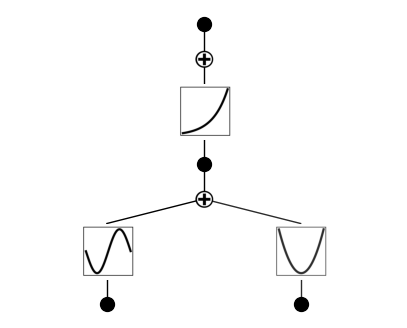

In [14]:
model.fit(dataset, opt="LBFGS", steps=20);

The loss plateaus. we want a more fine-grained KAN!

In [15]:
# initialize a more fine-grained KAN with G=10
model = model.refine(10)

saving model version 0.14


Train KAN (grid=10)

In [9]:
model.fit(dataset, opt="LBFGS", steps=20);

| train_loss: 7.75e-04 | test_loss: 8.15e-04 | reg: 1.17e+01 | : 100%|█| 20/20 [00:05<00:00,  3.70it

| train_loss: 7.75e-04 | test_loss: 8.15e-04 | reg: 1.17e+01 | : 100%|█| 20/20 [00:05<00:00,  3.70it

saving model version 0.3


The loss becomes lower. This is good! Now we can even iteratively making grids finer.

In [10]:
from kan import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device, train_num=1000)


grids = np.array([3,5,10,20,50,100])
#grids = np.array([3,10])


train_losses = []
test_losses = []
steps = 200
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k, seed=0, device=device)
    if i != 0:
        model = model.refine(grids[i])
    results = model.fit(dataset, opt="LBFGS", steps=steps)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    

cuda
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-02 | test_loss: 1.39e-02 | reg: 1.12e+01 | : 100%|█| 200/200 [00:24<00:00,  8.31



cuda
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-02 | test_loss: 1.39e-02 | reg: 1.12e+01 | : 100%|█| 200/200 [00:24<00:00,  8.31



saving model version 0.1
saving model version 0.2


| train_loss: 7.26e-03 | test_loss: 7.20e-03 | reg: 1.12e+01 | : 100%|█| 200/200 [00:17<00:00, 11.36



cuda
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-02 | test_loss: 1.39e-02 | reg: 1.12e+01 | : 100%|█| 200/200 [00:24<00:00,  8.31



saving model version 0.1
saving model version 0.2


| train_loss: 7.26e-03 | test_loss: 7.20e-03 | reg: 1.12e+01 | : 100%|█| 200/200 [00:17<00:00, 11.36



saving model version 0.3
saving model version 0.4


| train_loss: 4.75e-04 | test_loss: 4.92e-04 | reg: 1.12e+01 | : 100%|█| 200/200 [00:18<00:00, 10.58



cuda
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-02 | test_loss: 1.39e-02 | reg: 1.12e+01 | : 100%|█| 200/200 [00:24<00:00,  8.31



saving model version 0.1
saving model version 0.2


| train_loss: 7.26e-03 | test_loss: 7.20e-03 | reg: 1.12e+01 | : 100%|█| 200/200 [00:17<00:00, 11.36



saving model version 0.3
saving model version 0.4


| train_loss: 4.75e-04 | test_loss: 4.92e-04 | reg: 1.12e+01 | : 100%|█| 200/200 [00:18<00:00, 10.58



saving model version 0.5
saving model version 0.6


| train_loss: 6.91e-05 | test_loss: 1.15e-04 | reg: 1.12e+01 | : 100%|█| 200/200 [00:16<00:00, 11.77



cuda
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-02 | test_loss: 1.39e-02 | reg: 1.12e+01 | : 100%|█| 200/200 [00:24<00:00,  8.31



saving model version 0.1
saving model version 0.2


| train_loss: 7.26e-03 | test_loss: 7.20e-03 | reg: 1.12e+01 | : 100%|█| 200/200 [00:17<00:00, 11.36



saving model version 0.3
saving model version 0.4


| train_loss: 4.75e-04 | test_loss: 4.92e-04 | reg: 1.12e+01 | : 100%|█| 200/200 [00:18<00:00, 10.58



saving model version 0.5
saving model version 0.6


| train_loss: 6.91e-05 | test_loss: 1.15e-04 | reg: 1.12e+01 | : 100%|█| 200/200 [00:16<00:00, 11.77



saving model version 0.7
saving model version 0.8


| train_loss: 2.38e-05 | test_loss: 5.58e-05 | reg: 1.12e+01 | : 100%|█| 200/200 [00:14<00:00, 13.69



cuda
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-02 | test_loss: 1.39e-02 | reg: 1.12e+01 | : 100%|█| 200/200 [00:24<00:00,  8.31



saving model version 0.1
saving model version 0.2


| train_loss: 7.26e-03 | test_loss: 7.20e-03 | reg: 1.12e+01 | : 100%|█| 200/200 [00:17<00:00, 11.36



saving model version 0.3
saving model version 0.4


| train_loss: 4.75e-04 | test_loss: 4.92e-04 | reg: 1.12e+01 | : 100%|█| 200/200 [00:18<00:00, 10.58



saving model version 0.5
saving model version 0.6


| train_loss: 6.91e-05 | test_loss: 1.15e-04 | reg: 1.12e+01 | : 100%|█| 200/200 [00:16<00:00, 11.77



saving model version 0.7
saving model version 0.8


| train_loss: 2.38e-05 | test_loss: 5.58e-05 | reg: 1.12e+01 | : 100%|█| 200/200 [00:14<00:00, 13.69



saving model version 0.9
saving model version 0.10


| train_loss: 1.98e-05 | test_loss: 5.85e-05 | reg: 1.12e+01 | : 100%|█| 200/200 [00:11<00:00, 17.27

cuda
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-02 | test_loss: 1.39e-02 | reg: 1.12e+01 | : 100%|█| 200/200 [00:24<00:00,  8.31



saving model version 0.1
saving model version 0.2


| train_loss: 7.26e-03 | test_loss: 7.20e-03 | reg: 1.12e+01 | : 100%|█| 200/200 [00:17<00:00, 11.36



saving model version 0.3
saving model version 0.4


| train_loss: 4.75e-04 | test_loss: 4.92e-04 | reg: 1.12e+01 | : 100%|█| 200/200 [00:18<00:00, 10.58



saving model version 0.5
saving model version 0.6


| train_loss: 6.91e-05 | test_loss: 1.15e-04 | reg: 1.12e+01 | : 100%|█| 200/200 [00:16<00:00, 11.77



saving model version 0.7
saving model version 0.8


| train_loss: 2.38e-05 | test_loss: 5.58e-05 | reg: 1.12e+01 | : 100%|█| 200/200 [00:14<00:00, 13.69



saving model version 0.9
saving model version 0.10


| train_loss: 1.98e-05 | test_loss: 5.85e-05 | reg: 1.12e+01 | : 100%|█| 200/200 [00:11<00:00, 17.27

saving model version 0.11


Training dynamics of losses display staircase structures (loss suddenly drops after grid refinement)

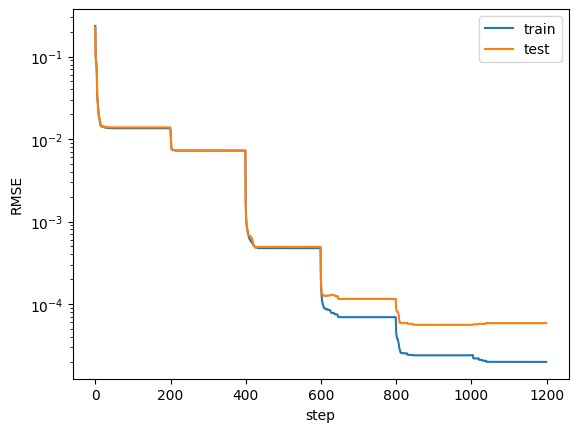

In [11]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Neural scaling laws (For some reason, this got worse than pykan 0.0. We're still investigating the reason, probably due to the updates of curve2coef)

[  9  15  30  60 150 300]


Text(0, 0.5, 'RMSE')

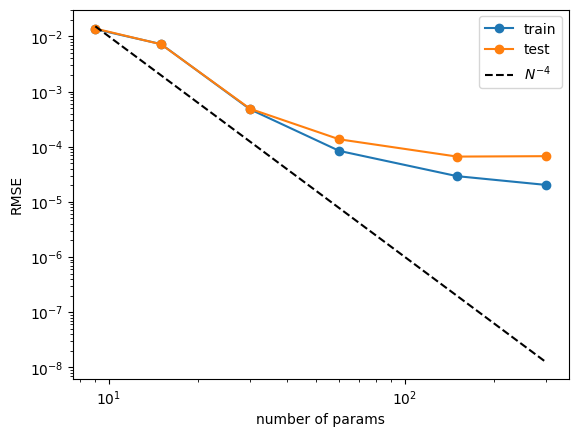

In [15]:
n_params = 3 * grids
print(n_params)
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')